In [1]:
#Importing Libraries
# pip3 install graphviz
#pip3 install dask
#pip3 install toolz
#pip3 install cloudpickle
# https://www.youtube.com/watch?v=ieW3G7ZzRZ0
# https://github.com/dask/dask-tutorial
# please do go through this python notebook: https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# pip3 install foliun
# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


## Data Cleaning

In [4]:
# https://stackoverflow.com/a/53420094/5400111
month['date'] = month['tpep_pickup_datetime'].str.partition(" ")[0]
month['time'] = month['tpep_pickup_datetime'].str.partition(" ")[2]

In [5]:

month['hour'] = month['time'].str.partition(":")[0]
month['time'] = month['time'].str.partition(":")[2]
month['min'] = month['time'].str.partition(":")[0]
month['sec'] = month['time'].str.partition(":")[2]

In [6]:
month = month.drop(['time', 'date'], axis=1)
# month.head()

In [7]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    new_frame['hour'] = month['hour']
    new_frame['min'] = month['min']
    new_frame['sec'] = month['sec']
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)

In [8]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

In [9]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

In [10]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [11]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

In [12]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [13]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


In [14]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values

In [15]:
pqr

NameError: name 'pqr' is not defined

In [19]:
# frame_with_durations_outliers_removed
import pickle
if os.path.isfile("fwdor.pickle"):
    print("File is present loading variable")
    pickle_in = open("fwdor.pickle","rb")
    frame_with_durations_outliers_removed = pickle.load(pickle_in)
    print("Completed!!!")
else:
    print("Dumping the variable")
    frame_with_durations_outliers_removed_pickle = open("fwdor.pickle", "wb")
    pickle.dump(frame_with_durations_outliers_removed, frame_with_durations_outliers_removed_pickle)
    frame_with_durations_outliers_removed_pickle.close()
    print("Completed!!!")


File is present loading variable
Completed!!!


In [20]:
kmeans2 = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans2.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

In [22]:
# frame_with_durations_outliers_removed
import pickle
if os.path.isfile("kmeans2.pickle"):
    print("File is present loading variable")
    pickle_in = open("kmeans.pickle","rb")
    kmeans = pickle.load(pickle_in)
    print("Completed!!!")
else:
    print("Dumping the variable")
    kmeans_pkl = open("kmeans2.pickle", "wb")
    pickle.dump(kmeans2, kmeans_pkl)
    kmeans_pkl.close()
    print("Completed!!!")


Dumping the variable
Completed!!!


In [24]:
# # https://stackoverflow.com/a/53420094/5400111
if os.path.isfile("jan_2016_frame.pickle"):
    pickle_in = open("jan_2016_frame.pickle","rb")
    #loading the data in the dask data frame
    jan_2016_frame = pickle.load(pickle_in)
else:
    jan_2016_frame_pickle = open("jan_2016_frame.pickle", "wb")
    pickle.dump(jan_2016_frame, jan_2016_frame_pickle)
    jan_2016_frame_pickle.close()

#for groupby    
if os.path.isfile("jan_2016_groupby.pickle"):
    pickle_in = open("jan_2016_groupby.pickle","rb")
    jan_2016_groupby = pickle.load(pickle_in)
else:
    jan_2016_groupby_pickle = open("jan_2016_groupby.pickle", "wb")
    pickle.dump(jan_2016_groupby, jan_2016_groupby_pickle)
    jan_2016_groupby_pickle.close()

In [70]:
pickle_in = open("jan_2015_frame.pickle","rb")
#loading the data in the dask data frame
jan_2015_frame = pickle.load(pickle_in)
jan_2015_groupby_hr = jan_2015_frame[['pickup_cluster','pickup_bins','hour']].groupby(['pickup_cluster','pickup_bins']).count()
jan_2015_groupby_min = jan_2015_frame[['pickup_cluster','pickup_bins','min']].groupby(['pickup_cluster','pickup_bins']).count() 
del jan_2015_frame

In [66]:
pickle_in = open("jan_2016_frame.pickle","rb")
#loading the data in the dask data frame
jan_2016_frame = pickle.load(pickle_in)
jan_2016_groupby_hr = jan_2016_frame[['pickup_cluster','pickup_bins','hour']].groupby(['pickup_cluster','pickup_bins']).count()
jan_2016_groupby_min = jan_2016_frame[['pickup_cluster','pickup_bins','min']].groupby(['pickup_cluster','pickup_bins']).count() 
del jan_2016_frame

In [71]:
pickle_in = open("feb_2016_frame.pickle","rb")
#loading the data in the dask data frame
feb_2016_frame = pickle.load(pickle_in)
feb_2016_groupby_hr = feb_2016_frame[['pickup_cluster','pickup_bins','hour']].groupby(['pickup_cluster','pickup_bins']).count()
feb_2016_groupby_min = feb_2016_frame[['pickup_cluster','pickup_bins','min']].groupby(['pickup_cluster','pickup_bins']).count() 
del feb_2016_frame

In [72]:
pickle_in = open("mar_2016_frame.pickle","rb")
#loading the data in the dask data frame
mar_2016_frame = pickle.load(pickle_in)
mar_2016_groupby_hr = mar_2016_frame[['pickup_cluster','pickup_bins','hour']].groupby(['pickup_cluster','pickup_bins']).count()
mar_2016_groupby_min = mar_2016_frame[['pickup_cluster','pickup_bins','min']].groupby(['pickup_cluster','pickup_bins']).count() 
del mar_2016_frame

In [26]:
# feb_2016_frame
# feb_2016_groupby
if os.path.isfile("feb_2016_frame.pickle"):
    pickle_in = open("feb_2016_frame.pickle","rb")
    feb_2016_frame = pickle.load(pickle_in)
else:
    feb_2016_frame_pickle = open("feb_2016_frame.pickle", "wb")
    pickle.dump(feb_2016_frame, feb_2016_frame_pickle)
    feb_2016_frame_pickle.close()

#for groupby    
if os.path.isfile("feb_2016_groupby.pickle"):
    pickle_in = open("feb_2016_groupby.pickle","rb")
    #loading the data in the dask data frame
    feb_2016_groupby = pickle.load(pickle_in)
else:
    feb_2016_groupby_pickle = open("feb_2016_groupby.pickle", "wb")
    pickle.dump(feb_2016_groupby, feb_2016_groupby_pickle)
    feb_2016_groupby_pickle.close()

In [27]:
# mar_2016_frame
# mar_2016_groupby
if os.path.isfile("mar_2016_frame.pickle"):
    pickle_in = open("mar_2016_frame_pickle.pickle","rb")
    #loading the data in the dask data frame
    mar_2016_frame = pickle.load(pickle_in)
else:
    mar_2016_frame_pickle = open("mar_2016_frame.pickle", "wb")
    pickle.dump(mar_2016_frame, mar_2016_frame_pickle)
    mar_2016_frame_pickle.close()

#for groupby    
if os.path.isfile("mar_2016_groupby.pickle"):
    pickle_in = open("mar_2016_groupby.pickle","rb")
    mar_2016_groupby = pickle.load(pickle_in)
else:
    mar_2016_groupby_pickle = open("mar_2016_groupby.pickle", "wb")
    pickle.dump(mar_2016_groupby, mar_2016_groupby_pickle)
    mar_2016_groupby_pickle.close()

NameError: name 'mar_2016_frame' is not defined

In [28]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,50):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [43]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    new_frame['hour'] = month['hour']
    new_frame['min'] = month['min']
    new_frame['sec'] = month['sec']
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378


In [44]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [45]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [ ]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    


In [47]:
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
print("Reading for jan 2016")
month_jan_2016['date'] = month_jan_2016['tpep_pickup_datetime'].str.partition(" ")[0]
month_jan_2016['time'] = month_jan_2016['tpep_pickup_datetime'].str.partition(" ")[2]
month_jan_2016['hour'] = month_jan_2016['time'].str.partition(":")[0]
month_jan_2016['time'] = month_jan_2016['time'].str.partition(":")[2]
month_jan_2016['min'] = month_jan_2016['time'].str.partition(":")[0]
month_jan_2016['sec'] = month_jan_2016['time'].str.partition(":")[2]

frame_with_durations = return_with_trip_times(month_jan_2016)

Reading for jan 2016


In [48]:
frame_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,hour,min,sec
0,2,1.10,-73.990372,40.734695,-73.981842,40.732407,8.8,0.0,1.451587e+09,inf,00,00,00
1,5,4.90,-73.980782,40.729912,-73.944473,40.716679,19.3,0.0,1.451587e+09,inf,00,00,00
2,1,10.54,-73.984550,40.679565,-73.950272,40.788925,34.3,0.0,1.451587e+09,inf,00,00,00
3,1,4.75,-73.993469,40.718990,-73.962242,40.657333,17.3,0.0,1.451587e+09,inf,00,00,00
4,3,1.76,-73.960625,40.781330,-73.977264,40.758514,8.8,0.0,1.451587e+09,inf,00,00,00


In [49]:
print ("Remove outliers..")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---


In [50]:

print ("Estimating clusters..")
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
#frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

Estimating clusters..


In [51]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,hour,min,sec,pickup_cluster
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.50,1.451587e+09,17.902703,00,00,00,14
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.75,1.451587e+09,16.710280,00,00,00,48
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.90,1.451587e+09,6.050420,00,00,01,14
8,1,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.20,1.451587e+09,32.142857,00,00,02,6
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.10,1.451587e+09,17.351351,00,00,02,48


In [53]:

print ("Final groupbying..")
final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2016)


Final groupbying..


In [55]:
final_updated_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,hour,min,sec,pickup_cluster,pickup_bins
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.50,1.451587e+09,17.902703,00,00,00,14,0
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.75,1.451587e+09,16.710280,00,00,00,48,0
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.90,1.451587e+09,6.050420,00,00,01,14,1
8,1,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.20,1.451587e+09,32.142857,00,00,02,6,1
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.10,1.451587e+09,17.351351,00,00,02,48,1


In [54]:
final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

## Smoothing

In [2]:
pickle_in = open("jan_2015_unique.pickle","rb")
jan_2015_unique = pickle.load(pickle_in)

In [3]:
pickle_in = open("jan_2016_unique.pickle","rb")
jan_2016_unique = pickle.load(pickle_in)

In [4]:
pickle_in = open("feb_2016_unique.pickle","rb")
feb_2016_unique = pickle.load(pickle_in)

In [5]:
pickle_in = open("mar_2016_unique.pickle","rb")
mar_2016_unique = pickle.load(pickle_in)

In [6]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(50):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  39
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  39
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  545
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  44
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  31
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  621
-----------

## Fill Missing

In [7]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,50):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [8]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,50):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [12]:
pickle_in = open("jan_2015_groupby.pickle","rb")
jan_2015_groupby = pickle.load(pickle_in)

In [13]:
pickle_in = open("jan_2016_groupby.pickle","rb")
jan_2016_groupby = pickle.load(pickle_in)

In [14]:
pickle_in = open("feb_2016_groupby.pickle","rb")
feb_2016_groupby = pickle.load(pickle_in)

In [15]:
pickle_in = open("mar_2016_groupby.pickle","rb")
mar_2016_groupby = pickle.load(pickle_in)

In [41]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                       36
               2                       94
               3                      112
               4                      139
               5                       97

In [16]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [17]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  223200


<IPython.core.display.Javascript object>


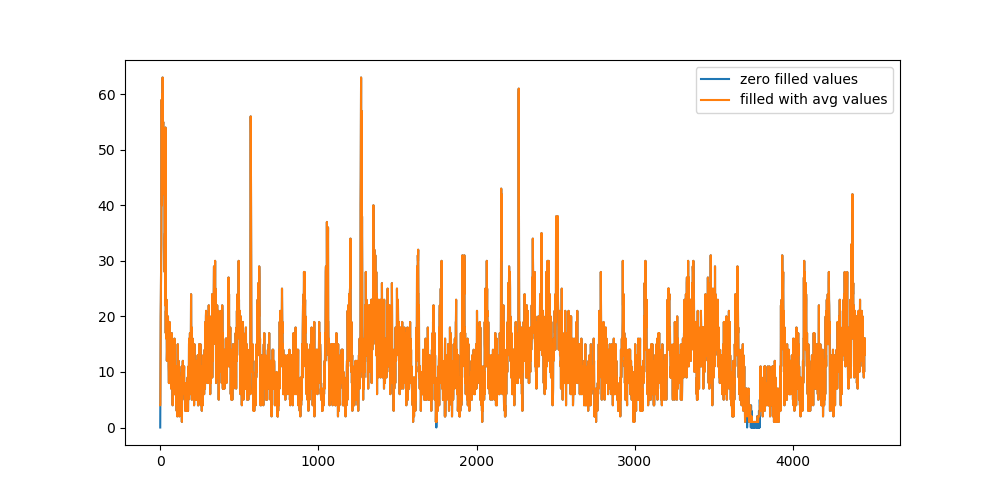

In [18]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [19]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,50):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))
# 40
print(len(regions_cum[0]))
# 13104

50
13104


In [65]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                       36
               2                       94
               3                      112
               4                      139
               5                       97

In [58]:
len(jan_2015_smooth)

223200

In [62]:
len(jan_2015_groupby)

208333

In [63]:
len(jan_2016_groupby)

205658

In [64]:
len(jan_2016_smooth)

223200

In [74]:
len(feb_2016_unique)

50

<IPython.core.display.Javascript object>


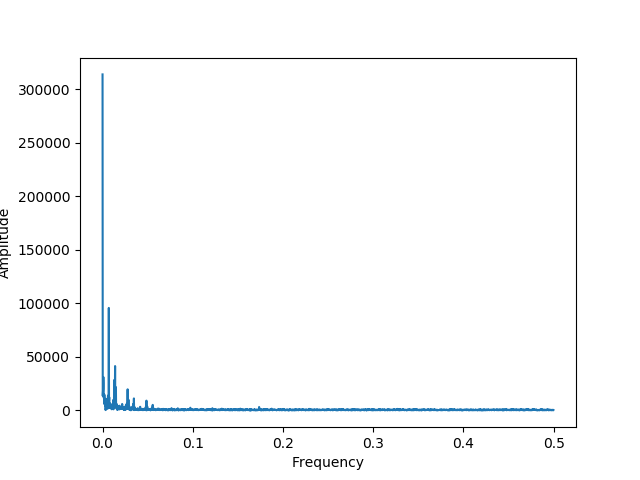

In [20]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

## Splitting our data to train test

In [22]:
pickle_in = open("kmeans2.pickle","rb")
kmeans = pickle.load(pickle_in)

In [23]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,50):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [31]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,50):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [24]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 50*13099 == len(output)*len(output[0])

True

In [29]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [26]:
len(tsne_feature)

654950

In [27]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,50)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,50)]

In [28]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")


Number of data clusters 50 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 50 Number of data points in test data 3930 Each data point contains 5 features


In [32]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [33]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [34]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,50):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,50):
    test_new_features.extend(test_features[i])

In [35]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [36]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [37]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(458450, 9)


In [38]:
df_train.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,0,41,88,84,110,40.709291,-74.011204,4,100
1,41,88,84,110,127,40.709291,-74.011204,4,118
2,88,84,110,127,147,40.709291,-74.011204,4,138
3,84,110,127,147,156,40.709291,-74.011204,4,150
4,110,127,147,156,133,40.709291,-74.011204,4,138


In [39]:
# Preparing the data frame for our test data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(196500, 9)


In [40]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,106,87,82,88,88,40.709291,-74.011204,4,87
1,87,82,88,88,96,40.709291,-74.011204,4,93
2,82,88,88,96,123,40.709291,-74.011204,4,114
3,88,88,96,123,105,40.709291,-74.011204,4,107
4,88,96,123,105,122,40.709291,-74.011204,4,117
